# Hidden-Shift problem for bent functions using the classiq platform

Here we implement the hidden shift algorithm for the familty of boolean bent functions.

First, make sure we have all necessary packages:

In [1]:
!pip install galois

On the first part, we assume we know how to implement the dual of $f$, and get $s$ according to the algorithm in [[1](#first)]: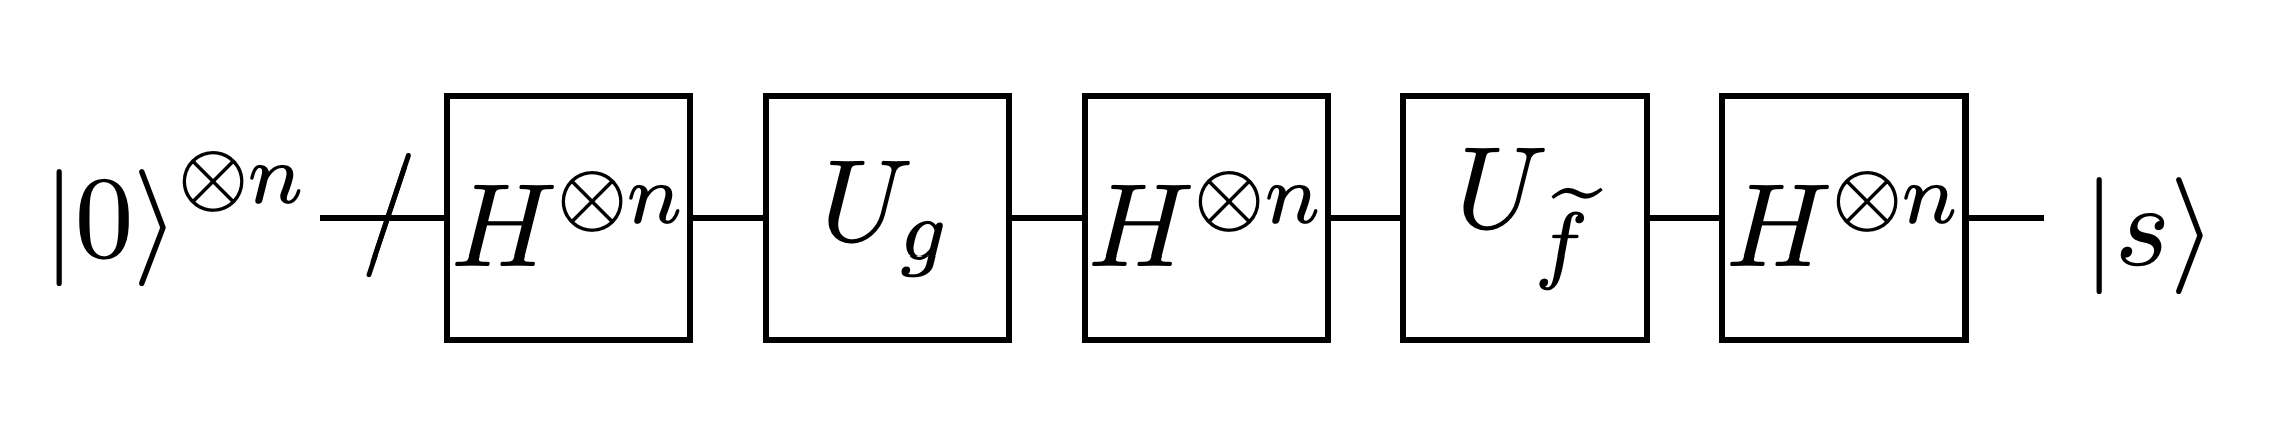

In [2]:
from classiq import (
    Constraints,
    Output,
    QArray,
    QBit,
    QCallable,
    QNum,
    allocate,
    bind,
    create_model,
    execute,
    hadamard_transform,
    invert,
    phase_oracle,
    qfunc,
    show,
    synthesize,
)


@qfunc
def hidden_shift(
    oracle: QCallable[QArray[QBit]],
    oracle_shifted: QCallable[QArray[QBit]],
    target: QArray[QBit],
) -> None:
    hadamard_transform(target)
    oracle_shifted(target)
    hadamard_transform(target)
    oracle(target)
    hadamard_transform(target)


NUM_VARIABLES = 4


@qfunc
def main(s: Output[QArray[QBit]]) -> None:

    @qfunc
    def arith_func(vars: QArray[QBit, NUM_VARIABLES], res: QBit):
        a, b, c, d = QBit("a"), QBit("b"), QBit("c"), QBit("d")
        bind(vars, [a, b, c, d])
        res ^= (a & b) ^ (c & d) == 1
        bind([a, b, c, d], vars)

    @qfunc
    def arith_func_shifted(vars: QArray[QBit, NUM_VARIABLES], res: QBit):
        a, b, c, d = QBit("a"), QBit("b"), QBit("c"), QBit("d")
        bind(vars, [a, b, c, d])
        res ^= ((a ^ 1) & b) ^ (c & d) == 1
        bind([a, b, c, d], vars)

    allocate(NUM_VARIABLES, s)

    hidden_shift(
        lambda y: phase_oracle(lambda vars, result: arith_func(vars, result), y),
        lambda y: phase_oracle(
            lambda vars, result: arith_func_shifted(vars, result), y
        ),
        s,
    )


constraints = Constraints(optimization_parameter="width")
qmod = create_model(main, constraints)
qprog = synthesize(qmod)

In [3]:
from classiq import write_qmod

write_qmod(qmod, "hidden_shift_simple")

In [4]:
from classiq import show

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/d31a7cae-c023-4371-8c3b-111808fe6302?version=0.41.0.dev39%2B79c8fd0855


In [5]:
from classiq.execution import ExecutionDetails

res = execute(qprog).result()
sample_results = res[0].value
sample_results.counts_of_output("s")

{'1000': 1000}

# More complex functions

We take a Maiorana-McFarland function with random permutation on the `y` and `h` function is the `and` operation between all the y-variables.

In [6]:
import random
from functools import reduce

import numpy as np

NUM_VARIABLES = 16

# Define the list
my_list = list(range(NUM_VARIABLES // 2))

# Get a random permutation
random.seed(1)
random.shuffle(my_list)

# Create a permutation dict and its inverse
perm_dict = {i: my_list[i] for i in range(NUM_VARIABLES // 2)}
inverse_perm_dict = {v: k for k, v in perm_dict.items()}


def h(y):
    return reduce(lambda a, b: a & b, [y[i] for i in range(NUM_VARIABLES // 2)])


def h_dual(x):
    return reduce(
        lambda a, b: a & b, [x[inverse_perm_dict[i]] for i in range(NUM_VARIABLES // 2)]
    )


def f_func(x, y):
    return (
        reduce(
            lambda a, b: a ^ b,
            [x[i] & y[perm_dict[i]] for i in range(NUM_VARIABLES // 2)],
        )
    ) ^ h(y)


def f_dual_func(x, y):
    return (
        reduce(
            lambda a, b: a ^ b,
            [x[inverse_perm_dict[i]] & y[i] for i in range(NUM_VARIABLES // 2)],
        )
    ) ^ h_dual(x)


def shifted(x, y, bits):
    x = x.copy()
    y = y.copy()
    for bit in bits:
        if bit < NUM_VARIABLES >> 2:
            x[bit] = x[bit] ^ 1
        else:
            bit = bit - NUM_VARIABLES // 2
            y[bit] = y[bit] ^ 1
    return f_func(x, y)

In [7]:
shifted_bits = [1, 3, 9]
g_func = lambda x, y: shifted(x, y, shifted_bits)

## Now create the ciruit:

In [8]:
@qfunc
def g_qfunc(vars: QArray[QBit, NUM_VARIABLES], res: QBit):
    qubit_vars = [QBit(f"x{i+1}") for i in range(NUM_VARIABLES)]
    bind(vars, qubit_vars)
    x = qubit_vars[: NUM_VARIABLES // 2]
    y = qubit_vars[NUM_VARIABLES // 2 :]
    print("g:", g_func(x, y))
    res ^= (g_func(x, y)) == 1
    bind(qubit_vars, vars)


@qfunc
def f_dual_qfunc(vars: QArray[QBit, NUM_VARIABLES], res: QBit):
    qubit_vars = [QBit(f"x{i+1}") for i in range(NUM_VARIABLES)]
    bind(vars, qubit_vars)
    x = qubit_vars[: NUM_VARIABLES // 2]
    y = qubit_vars[NUM_VARIABLES // 2 :]
    print("f_dual:", f_dual_func(x, y))
    res ^= (f_dual_func(x, y)) == 1
    bind(qubit_vars, vars)


@qfunc
def f_qfunc(vars: QArray[QBit, NUM_VARIABLES], res: QBit):
    qubit_vars = [QBit(f"x{i+1}") for i in range(NUM_VARIABLES)]
    bind(vars, qubit_vars)
    x = qubit_vars[: NUM_VARIABLES // 2]
    y = qubit_vars[NUM_VARIABLES // 2 :]
    print("f:", f_func(x, y))
    res ^= (f_func(x, y)) == 1
    bind(qubit_vars, vars)


@qfunc
def main(s: Output[QArray[QBit]]) -> None:
    allocate(NUM_VARIABLES, s)

    hidden_shift(
        lambda y: phase_oracle(lambda vars, result: f_dual_qfunc(vars, result), y),
        lambda y: phase_oracle(lambda vars, result: g_qfunc(vars, result), y),
        s,
    )


constraints = Constraints(optimization_parameter="width")
qmod = create_model(main, constraints=constraints)

f_dual: (((((((((x6) & (x9)) ^ ((x3) & (x10))) ^ ((x8) & (x11))) ^ ((x1) & (x12))) ^ ((x7) & (x13))) ^ ((x4) & (x14))) ^ ((x2) & (x15))) ^ ((x5) & (x16))) ^ ((((((((x6) & (x3)) & (x8)) & (x1)) & (x7)) & (x4)) & (x2)) & (x5))
g: (((((((((x1) & (x12)) ^ (((x2) ^ 1) & (x15))) ^ ((x3) & ((x10) ^ 1))) ^ (((x4) ^ 1) & (x14))) ^ ((x5) & (x16))) ^ ((x6) & (x9))) ^ ((x7) & (x13))) ^ ((x8) & (x11))) ^ ((((((((x9) & ((x10) ^ 1)) & (x11)) & (x12)) & (x13)) & (x14)) & (x15)) & (x16))


In [9]:
write_qmod(qmod, "hidden_shift_complex")

In [10]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/fb944da8-cb3b-4630-880b-413335d266d7?version=0.41.0.dev39%2B79c8fd0855


In [11]:
from classiq.execution import ExecutionDetails

res = execute(qprog).result()
sample_results = res[0].value
sample_results.counts_of_output("s")

{'0101000001000000': 1000}

In [12]:
expected_s = "".join("1" if i in shifted_bits else "0" for i in range(NUM_VARIABLES))
assert list(sample_results.counts_of_output("s").keys())[0] == expected_s

And indeed we got the correct shift!

# Hidden Shift without the dual function

We now use the second algorithm described in [[2](#second)]. This algorithm only requires to implement $f$ and not its dual, however requires $O(n)$ samples from the circuit.
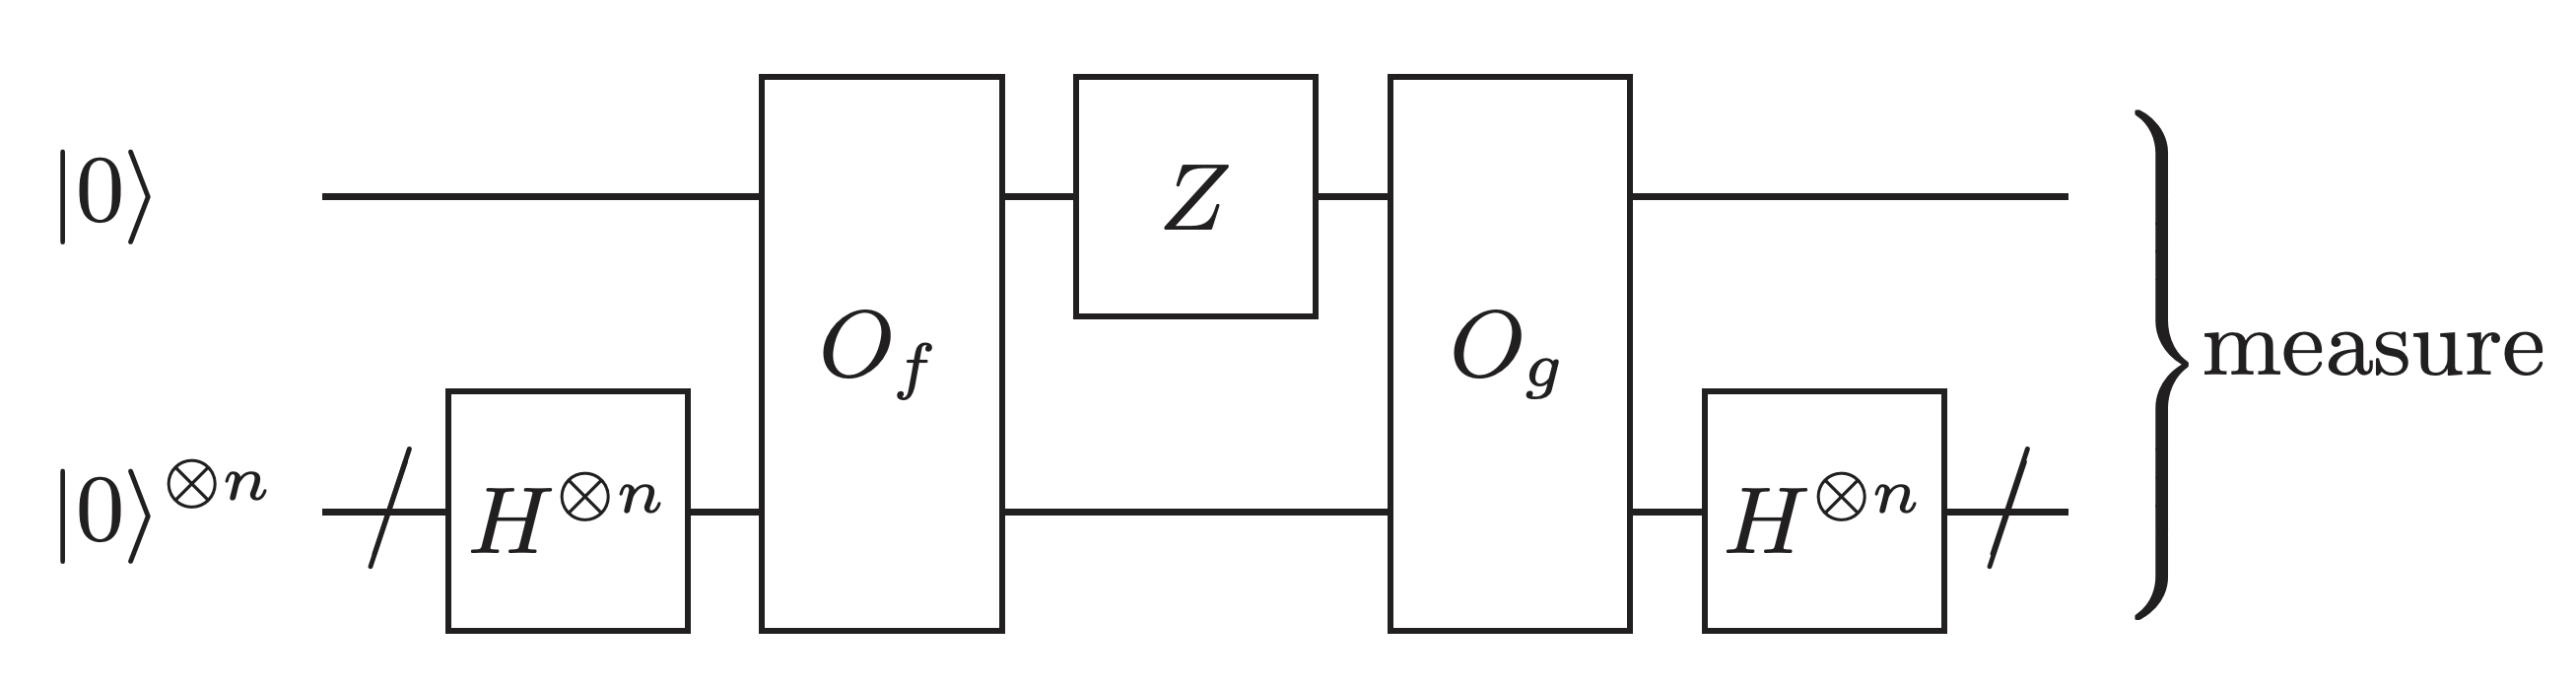

In [13]:
from classiq import Z


@qfunc
def hidden_shift_no_dual(
    oracle: QCallable[QArray[QBit], QBit],
    oracle_shifted: QCallable[QArray[QBit], QBit],
    target: QArray[QBit],
    ind: QBit,
) -> None:
    hadamard_transform(target)
    oracle(target, ind)
    Z(ind)
    oracle_shifted(target, ind)
    hadamard_transform(target)


NUM_VARIABLES = 16


@qfunc
def main(target: Output[QArray[QBit]], ind: Output[QBit]) -> None:

    allocate(NUM_VARIABLES, target)
    allocate(1, ind)

    hidden_shift_no_dual(
        lambda vars, result: f_qfunc(vars, result),
        lambda vars, result: g_qfunc(vars, result),
        target,
        ind,
    )


constraints = Constraints(optimization_parameter="width")
qmod = create_model(main, constraints)

f: (((((((((x1) & (x12)) ^ ((x2) & (x15))) ^ ((x3) & (x10))) ^ ((x4) & (x14))) ^ ((x5) & (x16))) ^ ((x6) & (x9))) ^ ((x7) & (x13))) ^ ((x8) & (x11))) ^ ((((((((x9) & (x10)) & (x11)) & (x12)) & (x13)) & (x14)) & (x15)) & (x16))
g: (((((((((x1) & (x12)) ^ (((x2) ^ 1) & (x15))) ^ ((x3) & ((x10) ^ 1))) ^ (((x4) ^ 1) & (x14))) ^ ((x5) & (x16))) ^ ((x6) & (x9))) ^ ((x7) & (x13))) ^ ((x8) & (x11))) ^ ((((((((x9) & ((x10) ^ 1)) & (x11)) & (x12)) & (x13)) & (x14)) & (x15)) & (x16))


In [14]:
write_qmod(qmod, "hidden_shift_no_dual")

In [15]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/04a66e6d-2062-4560-96eb-833b34502fcb?version=0.41.0.dev39%2B79c8fd0855


In [16]:
from classiq.execution import ExecutionDetails

res = execute(qprog).result()
sample_results = res[0].value

Out of the sampled results, we look for $n$ independent samples, from which we can extract s.
1000 samples should be enough with a very high probability.

In [17]:
# The galois library is a package that extends NumPy arrays to operate over finite fields.
# we wlll use it as our equations are binary equations
import galois

# here we work over boolean arithmetics - F(2)
GF = galois.GF(2)


def is_independent_set(vectors):
    matrix = GF(vectors)
    rank = np.linalg.matrix_rank(matrix)
    if rank == len(vectors):
        return True
    else:
        return False


samples = [
    ([int(i) for i in u], int(b))
    for u, b in sample_results.counts_of_multiple_outputs(["target", "ind"]).keys()
]

ind_v = []
ind_b = []
for v, b in samples:
    if is_independent_set(ind_v + [v]):
        ind_v.append(v)
        ind_b.append(b)
        if len(ind_v) == len(v):
            # reached max set
            break

assert len(ind_v) == len(v)

We now left with solving the equation and extracting $s$:

In [18]:
A = np.array(ind_v)
b = np.array(ind_b)

# Solve the linear system
s = np.linalg.solve(GF(A), GF(b))
s

GF([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], order=2)

And we got successfully the same shift.

In [19]:
assert "".join(str(i) for i in s) == expected_s

## References

<a id='first'>[1]</a>: [Quantum algorithms for highly non-linear Boolean functions](https://arxiv.org/abs/0811.3208)

<a id='second'>[2]</a>: [Quantum algorithm for the Boolean hidden shift problem](https://arxiv.org/abs/1103.3017)
